<a href="https://colab.research.google.com/github/venk221/SfM/blob/master/SfM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import sys
from google.colab import drive
drive.mount('/content/gdrive')
import glob
import cv2
from google.colab.patches import cv2_imshow
import math 
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import scipy.optimize as opt
K = np.array([[531.122155322710, 0, 407.192550839899],[0, 531.541737503901, 313.308715048366],[0, 0 ,1]])

Mounted at /content/gdrive


In [2]:


def mat(numMatches, cor, img2):
  img2 = float(img2)
  if numMatches == float(2):
    if cor[6] == img2:
      x_mat1 = cor[7]
      y_mat1 = cor[8]
      return np.array([x_mat1, y_mat1])
    else:
      return np.array([-1, -1])
  if numMatches == float(3):
    if cor[6] == img2:
      x_mat1 = cor[7]
      y_mat1 = cor[8]
      return np.array([x_mat1, y_mat1])
    elif cor[9] == img2:
      x_mat1 = cor[10]
      y_mat1 = cor[11]
      return np.array([x_mat1, y_mat1])
    else:
      return np.array([-1, -1])
  if numMatches == float(4):
    if cor[6] == img2:
      x_mat1 = cor[7]
      y_mat1 = cor[8]
      return np.array([x_mat1, y_mat1])
    elif cor[9] == img2:
      x_mat1 = cor[10]
      y_mat1 = cor[11]
      return np.array([x_mat1, y_mat1])
    elif cor[12] == img2:
      x_mat1 = cor[13]
      y_mat1 = cor[14]
      return np.array([x_mat1, y_mat1])
    else:
      return np.array([-1, -1])
  if numMatches == float(5):
    if cor[6] == img2:
      x_mat1 = cor[7]
      y_mat1 = cor[8]
      return np.array([x_mat1, y_mat1])
    elif cor[9] == img2:
      x_mat1 = cor[10]
      y_mat1 = cor[11]
      return np.array([x_mat1, y_mat1])
    elif cor[12] == img2:
      x_mat1 = cor[13]
      y_mat1 = cor[14]
      return np.array([x_mat1, y_mat1])
    elif cor[15] == img2:
      x_mat1 = cor[16]
      y_mat1 = cor[17]
      return np.array([x_mat1, y_mat1])
    else:
      return np.array([-1, -1])
  if numMatches > float(6):
    print('olala')

def findMatches(img1, img2):
  with open('/content/gdrive/MyDrive/Colab Notebooks/P3Data/'+ 'matching' + str(img1) + '.txt') as f:
      Prev_contents = f.readlines()       
      nfeat = len(Prev_contents) - 1
      # print(f"number of features in matching{img1}.txt are {nfeat}")
      # print(Prev_contents)
      contents = []
      for k,line in enumerate(Prev_contents):
        if k != 0:
          # contents = [float(i) for i in line]
          line = line.rstrip('\n')
          line_elements = line.split()
          corners = [float(j) for j in line_elements]
          # print(type(cor[random.randint(1,6)]))
          contents.append(corners)
      # print(contents)
      RGB_vals = []
      coordinates = []
      matchingCoor = []
      for k,line in enumerate(contents):
        # if k == 963:  
          cor = np.array(line)
          numMatches = cor[0]
          r = cor[1]
          g = cor[2]
          b = cor[3]
          x_cor = cor[4]
          y_cor = cor[5]
          img_id1 = cor[6]
          matching_cor = mat(numMatches, cor, img2)
          # print(type(matching_cor))
          # print(matching_cor)
          RGB_vals.append([r,g,b])
          coordinates.append([x_cor, y_cor])
          # if matching_cor != None:
          matchingCoor.append(matching_cor)
      matchingCoor = np.array(matchingCoor)
      # matchingCoor[matchingCoor==-1]=[-1,-1]
      # print(matchingCoor)
      matchingCoor = np.reshape(matchingCoor, (nfeat,2))
      RGB_vals = np.array(RGB_vals)
      coordinates = np.array(coordinates)
      firstcol = img1*np.ones((nfeat,1))
      fourthcol = img2*np.ones((nfeat,1))
      # print(f"firstcol={firstcol.shape}, RGB_vals={RGB_vals.shape}, coordinates={coordinates.shape},fourthcol={fourthcol.shape}, matchingCoor={matchingCoor.shape}")
      InfoAll = np.append(firstcol, RGB_vals,  axis = 1)
      InfoAll = np.append(InfoAll, coordinates,  axis = 1)
      InfoAll = np.append(InfoAll, fourthcol,  axis = 1)
      InfoAll = np.append(InfoAll, matchingCoor,  axis = 1)
      # print(InfoAll.shape)
      # print((matchingCoor.shape[0]))
      count = 0
      for k,j in enumerate((matchingCoor)):
        if j[0] == -1:
          count = count+1
      # print(count)
      # print(InfoAll)
      newinfo = []
      for row in InfoAll:
        if row[7] != -1:
          newinfo.append(row)
      newinfo = np.array(newinfo) 
      # print(newinfo.shape)
      return newinfo

matches1and2 = findMatches(1,2)


def EstimateFundamentalMatrix(a, b):
  # print(np.sum(a[:,0]))
  n = a.shape[0]
  # print(a,b)
  """Normalization - Eight Point Algorithm"""
  #Calculating means
  ua = (1/n)*(np.sum(a[:,0]))
  va = (1/n)*(np.sum(a[:,1]))
  ub = (1/n)*(np.sum(b[:,0]))
  vb = (1/n)*(np.sum(b[:,1]))
  ua_dash, va_dash = a[:,0] - ua, a[:,1] - va
  ub_dash, vb_dash = b[:,0] - ub, b[:,1] - vb 
  #Finding scale = https://en.wikipedia.org/wiki/Eight-point_algorithm#:~:text=The%20eight%2Dpoint%20algorithm%20is,case%20of%20the%20essential%20matrix.
  sa = n / np.sum(((ua_dash)**2 + (va_dash)**2)**(0.5))  #(2**(0.5))/(((1/n)*(np.mean((ua_dash**2)+(va_dash**2))))**(0.5))
  sb = n / np.sum(((ub_dash)**2 + (vb_dash)**2)**(0.5))  #(2**(0.5))/(((1/n)*(np.mean((ub_dash**2)+(vb_dash**2))))**(0.5)) 
  scaleA = np.array([[sa, 0, 0],[0, sa, 0],[0, 0, 1]])
  scaleB = np.array([[sb, 0, 0],[0, sb, 0],[0, 0, 1]])
  translationA = np.array([[1, 0, -ua],[0, 1, -va],[0, 0 , 1]])
  translationB = np.array([[1, 0, -ub],[0, 1, -vb],[0, 0 , 1]])
  transformation_A_2D = np.matmul(scaleA, translationA)
  transformation_B_2D = np.matmul(scaleB, translationB) 
  aPrev = np.column_stack((a, np.ones(len(a))))
  bPrev = np.column_stack((b, np.ones(len(b))))
  a_normalized = np.matmul(transformation_A_2D, aPrev.transpose())
  b_normalized = np.matmul(transformation_B_2D, bPrev.transpose())
  anew, bnew = a_normalized.transpose(), b_normalized.transpose()
  A = []
  for i in range(0, anew.shape[0]): #anew.shape[0]
    x1, y1 = anew[i,0], anew[i,1]
    x2, y2 = bnew[i,0], bnew[i,1]
    A.append([x1*x2, y1*x2, x2, x1*y2, y1*y2, y2, x1, y1, 1])  #[x1*x2, y2*x1, x1, x2*y1, y1*y2, y1, x2, y2, 1] [x1*x2, y1*x2, x2, x1*y2, y1*y2, y2, x1, y1, 1]
  A = np.array(A)
  _, s, v = np.linalg.svd(A, full_matrices=True)
  v = v.transpose()
  F = v[:,-1]
  F = np.reshape(F, (3, 3))
  """SVD Cleanup"""
  F = np.dot(transformation_B_2D.transpose(), np.dot(F, transformation_A_2D))
  u, s1, vt = np.linalg.svd(F)
  s = np.diag(s1)
  s[2,2] = 0
  F = np.dot(u, np.dot(s, vt))
  F = F/F[2,2]
  return F

# F = EstimateFundamentalMatrix(matches1and2[:,4:6], matches1and2[:,7:9])  

def error(x1,x2,f):
  x1 = np.append(x1,1) #np.reshape(x1,(1,2))
  x1 = np.reshape(x1,(3,1))
  x2 = np.append(x2,1)
  x2 = np.reshape(x2, (1,3))
  # print(f"bhok = {x1, x1.shape}, x2={x2, x2.shape}, f={f.shape}")
  err = np.dot(x2, np.dot(f, x1))
  return np.abs(err)
  
def GetInlierRANSANC(a,b):
  num_inliers = 0
  iterations = 2000
  threshold = 0.005
  ffinal = 0
  final_inliers = []
  max = a.shape[0]
  # print(a[0,:].shape)
  for i in range(iterations):
      indices = []  
    # if i == 99:
      for i in range(0, 8):
        indices.append(random.randint(0, max-1))
      x1 = a[indices,:]
      x2 = b[indices,:]
      ftemp = EstimateFundamentalMatrix(x1,x2)
      inliers = []
      # if (len(a) > 8) and (len(b) > 8):
      for j in range(len(a)):
        # if j == 1:
        err = error(a[j,:], b[j,:], ftemp)
        # print(err)
        if err < threshold:
                # print("kaka")
                inliers.append([j])
                # print(inliers))
      if len(inliers) > num_inliers:
          num_inliers = len(inliers)
          final_inliers = inliers
  final_inliers = np.array(final_inliers)
  pointsWithInliersA = a[final_inliers]
  pointsWithInliersB = b[final_inliers]
  pointsWithInliersA = np.reshape(pointsWithInliersA, (pointsWithInliersA.shape[0],2))
  pointsWithInliersB = np.reshape(pointsWithInliersB, (pointsWithInliersB.shape[0],2))
  # print(pointsWithInliersB) 
  ffinal = EstimateFundamentalMatrix(pointsWithInliersA, pointsWithInliersB)
  print("best fundamental matrix",ffinal, "with no of inliers", num_inliers)
  return ffinal, final_inliers
 
bestF, inliers = GetInlierRANSANC(matches1and2[:,4:6], matches1and2[:,7:9])

def EssentialMatrixFromFundamentalMatrix(F, K):
  E = np.dot(K.T, np.dot(F, K))
  u, s, vt = np.linalg.svd(E)
  E = np.dot(u, np.dot(np.diag([1, 1, 0]), vt))
  return E

E = EssentialMatrixFromFundamentalMatrix(bestF, K)
print(E)

best fundamental matrix [[-4.55812106e-08 -2.74880252e-05  1.19497346e-02]
 [ 3.00050094e-05  3.26321865e-06 -3.36820509e-02]
 [-1.37439897e-02  3.18314135e-02  1.00000000e+00]] with no of inliers 222
[[ 0.00208377 -0.55137141  0.12147421]
 [ 0.60804747  0.05567841 -0.77759075]
 [-0.17084874  0.82076577  0.03023771]]


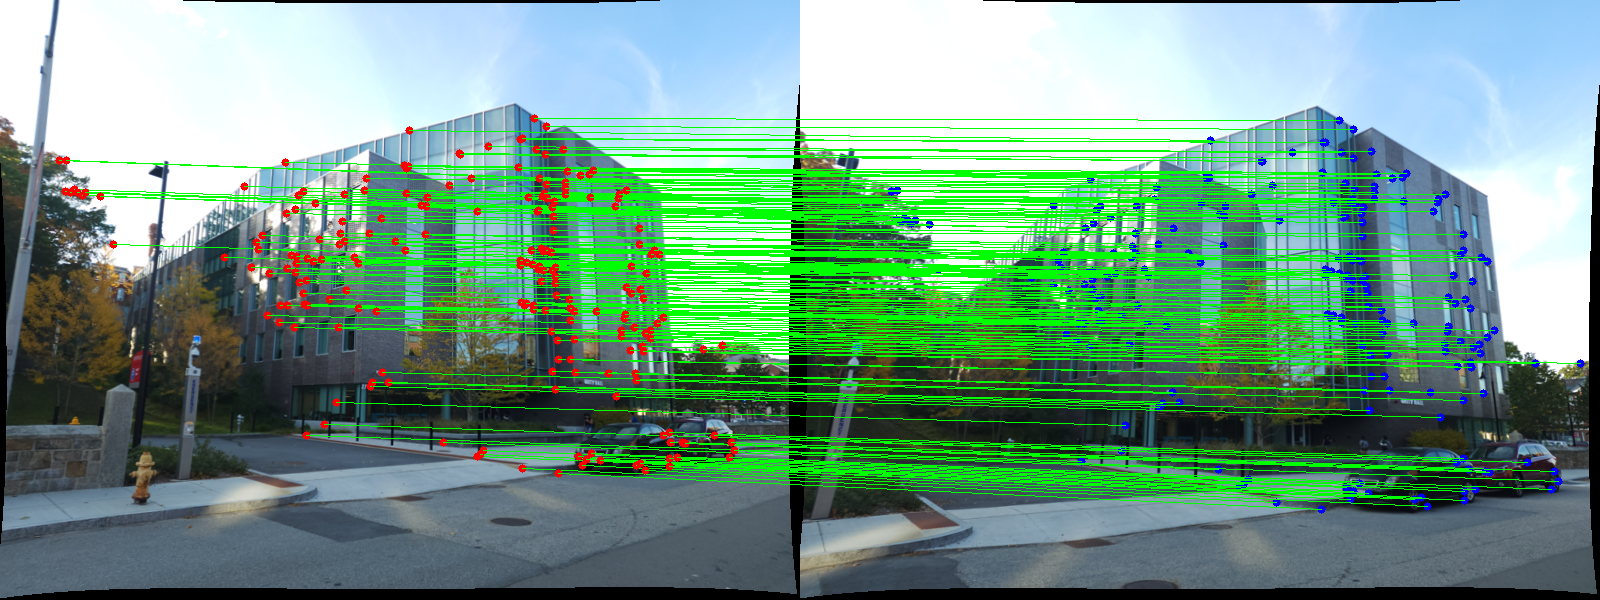

In [3]:
inliers = np.array(inliers)
inliers1and2 = matches1and2[inliers]
# print(inliers1and2.shape)
inliers1and2 = np.reshape(inliers1and2, (inliers1and2.shape[0],9))
# print(inliers1and2.shape)
# print(inliers1and2[:,4:6])

def DrawInliers(i, j, inliers_a, inliers_b):
    img1 = cv2.imread('/content/gdrive/MyDrive/Colab Notebooks/P3Data/' + str(i) + '.png')
    img2 = cv2.imread('/content/gdrive/MyDrive/Colab Notebooks/P3Data/' + str(j) + '.png')

    rows1, cols1 = img1.shape[:2]
    rows2, cols2 = img2.shape[:2]
    out = np.zeros((max([rows1, rows2]), cols1 + cols2, 3), dtype='uint8')
    out[:rows1, :cols1, :] = img1
    out[:rows2, cols1:cols1 + cols2, :] = img2
    radius = 4
    BLUE = (255, 0, 0)
    GREEN = (0, 255, 0)
    RED = (0, 0, 255)
    thickness = 1
    # print(f"testing = {inliers_a}")
    assert len(inliers_a) == len(inliers_b), "inliers in images not equal"
    for m in range(0, len(inliers_a)):

        cv2.circle(out, (int(inliers_a[m,0]), int(inliers_a[m,1])), radius,
                   RED, -1)

        cv2.circle(out, (int(inliers_b[m][0]) + cols1, int(inliers_b[m][1])),
                   radius, BLUE, -1)
        
        cv2.line(out, (int(inliers_a[m][0]), int(inliers_a[m][1])),
                 (int(inliers_b[m][0]) + cols1, int(inliers_b[m][1])), GREEN,
                 thickness)
    cv2_imshow(out)

DrawInliers(1, 2, inliers1and2[:,4:6], inliers1and2[:,7:9])

In [4]:
def ExtractCameraPose(E, K):
  w = np.array([[0,-1,0],[1,0,0],[0,0,1]])
  u, s, vt = np.linalg.svd(E)
  P = []
  R = []
  C = []
  C.append(u[:,2])
  C.append(-u[:,2])
  C.append(u[:,2])
  C.append(-u[:,2])
  C = np.array(C)
  # print("trey",C)
  R.append(np.matmul(u,np.matmul(w,vt)))
  R.append(np.matmul(u,np.matmul(w,vt)))
  R.append(np.matmul(u,np.matmul(w.transpose(),vt)))
  R.append(np.matmul(u,np.matmul(w.transpose(),vt)))
  R = np.array(R)
  # print("treyR",R)
  P.append(np.matmul(np.matmul(K,R[0,:,:]),np.array([[1,0,0,C[0,0]],[0,1,0,C[0,1]],[0,0,1,C[0,2]]])))
  P.append(np.matmul(np.matmul(K,R[1,:,:]),np.array([[1,0,0,C[1,0]],[0,1,0,C[1,1]],[0,0,1,C[1,2]]])))
  P.append(np.matmul(np.matmul(K,R[2,:,:]),np.array([[1,0,0,C[2,0]],[0,1,0,C[2,1]],[0,0,1,C[2,2]]])))  
  P.append(np.matmul(np.matmul(K,R[3,:,:]),np.array([[1,0,0,C[3,0]],[0,1,0,C[3,1]],[0,0,1,C[3,2]]])))
  P = np.array(P)

  Rnew = []
  Cnew = []

  epsilon=10e-6
  for r,c in zip(R,C):
    if (np.linalg.det(r) <= float(1)+epsilon) or (np.linalg.det(r)>=float(1)-epsilon) :
      Rnew.append(r)
      Cnew.append(c)
    elif np.linalg.det(r) < 0:
      Rnew.append(-r)
      Cnew.append(-c)

    else:
      print('Exit')
      print(np.linalg.det(r))
  Rnew = np.array(Rnew)
  Cnew = np.array(Cnew)
  # print("test",Rnew, Cnew)   
  return Cnew, Rnew, P

C, R, P = ExtractCameraPose(E, K)
# print(R)
# print(C)
def skewsym(x):
   return np.array([[0, -x[2], x[1]], [x[2], 0, -x[0]], [-x[1], x[0], 0]])

def LinearTriangulation(K, C1, R1, C2, R2, x1, x2):
  ProjectionMatrix = np.zeros((3,4,2))
  temp1 = np.append(np.identity(3), -C1, axis=1)
  temp2 = np.array([[1,0,0,C2[0]],[0,1,0,C2[1]],[0,0,1,C2[2]]])
  ProjectionMatrix[:,:,0] = np.matmul(K, np.matmul(R1, temp1))
  ProjectionMatrix[:,:,1] = np.matmul(K, np.matmul(R2, temp2))
  pts1 = np.append(x1, np.reshape(np.ones((x1.shape[0])),(x1.shape[0],1)), axis=1)
  pts2 = np.append(x2, np.reshape(np.ones((x2.shape[0])),(x2.shape[0],1)), axis=1)
  X = []
  for i in range(pts1.shape[0]):
    tem1 = np.matmul(skewsym(pts1[i,:]), ProjectionMatrix[:,:,0])
    tem2 = np.matmul(skewsym(pts2[i,:]), ProjectionMatrix[:,:,1])
    A = np.vstack((tem1, tem2))
    u,s,vt = np.linalg.svd(A)
    x = vt[-1] / vt[-1, -1]
    x = np.reshape(x, (len(x), -1)).transpose()
    X.append(x)
  X = np.array(X)
  return X
    

X_set = []
for n in range(0, 4):
      X1 = LinearTriangulation(K, np.zeros((3, 1)), np.identity(3),
                                C[n,:].T, R[n,:,:], np.float32(inliers1and2[:,4:6]),
                                np.float32(inliers1and2[:,7:9]))
      X_set.append(X1)
# (inliers1and2[:,4:6], inliers1and2[:,7:9])

[[[-0.99649595 -0.0215699  -0.08081183]
  [ 0.02577284 -0.99834902 -0.05133211]
  [ 0.07957119  0.05323499 -0.99540668]]

 [[-0.99649595 -0.0215699  -0.08081183]
  [ 0.02577284 -0.99834902 -0.05133211]
  [ 0.07957119  0.05323499 -0.99540668]]

 [[-0.28331095 -0.20735897 -0.93634244]
  [-0.258521    0.95671558 -0.13364953]
  [-0.92352683 -0.2041998   0.32465465]]

 [[-0.28331095 -0.20735897 -0.93634244]
  [-0.258521    0.95671558 -0.13364953]
  [-0.92352683 -0.2041998   0.32465465]]]
[[ 0.82536612  0.15010268  0.54427929]
 [-0.82536612 -0.15010268 -0.54427929]
 [ 0.82536612  0.15010268  0.54427929]
 [-0.82536612 -0.15010268 -0.54427929]]


(4, 222, 4)


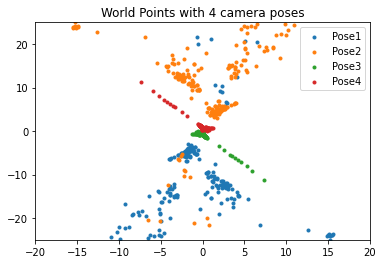

In [14]:
X_set = np.array(X_set)
print(X_set.shape)
X_set = np.reshape(X_set, (4,X_set.shape[1],4))
# print(X_set)
# scaler = MinMaxScaler((-0.00000001,0.00000001))
# Xnew = scaler.fit_transform(X_set[:,:,0])
# print(Xnew)
# Znew = scaler.fit_transform(X_set[:,:,2])
# # print(Znew)
# plt.scatter(Xnew, Znew)
# plt.show()
# plt.scatter(X_set[1,:,0], X_set[1,:,2])
# plt.show()
x1, z1 = X_set[0,:,0], X_set[0,:,2]
x2, z2 = X_set[1,:,0], X_set[1,:,2]
x3, z3 = X_set[2,:,0], X_set[2,:,2]
x4, z4 = X_set[3,:,0], X_set[3,:,2]
plt.scatter(x1,z1, marker = '.', cmap = 'bone',label='Pose1')
plt.scatter(x2,z2, marker = '.', cmap = 'spring',label='Pose2')
plt.scatter(x3,z3, marker = '.', cmap = 'cool',label='Pose3')
plt.scatter(x4,z4, marker = '.', cmap = 'pink',label='Pose4')
plt.title("World Points with 4 camera poses")
plt.xlim([-20,20])
plt.ylim([-25,25])
plt.legend()
plt.show()




(3,) (3, 3) (222, 3)


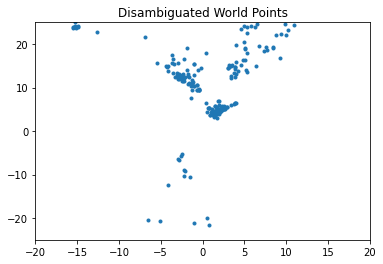

In [15]:
def DisambiguateCameraPose(C_all, R_all, X_all):
    max_points=0
    best_index=0
    X_all = X_all[:,:,:3]
    for i in range(4):
        num_world_points=X_all[i].shape[1]
        num_points_satisfying_condtion=0
        for j in range(num_world_points):
            r3=R_all[i,2,:]   #[i][2,:] 
            this_image_world_points=X_all[i,:,:]
            if (np.dot(r3,this_image_world_points[j,:]-C_all[i,:]) and this_image_world_points[j,2]>=0):
                num_points_satisfying_condtion+=1
        if num_points_satisfying_condtion>max_points:
            max_points=num_points_satisfying_condtion
            best_index=i
    return C_all[best_index],R_all[best_index],X_all[best_index]


Cbest, Rbest, Xbest = DisambiguateCameraPose(C, R, X_set)
print(Cbest.shape, Rbest.shape, Xbest.shape)
Cbest = np.reshape(Cbest, (Cbest.shape[0],1))
plt.scatter(Xbest[:,0], Xbest[:,2],marker='.')
plt.title("Disambiguated World Points")
plt.xlim([-20,20])
plt.ylim([-25,25])
plt.show()

In [7]:
def NonLinearTriangulation(K, x1, x2, R1, C1, R2, C2, X_init):
  if x1.shape[0] != X_init.shape[0] or x1.shape[0] != X_init.shape[0]:
    print("shapes are not equal")
  else:
    init = X_init
    init=init.flatten()
    # minimize(init, K, x1, x2, R1, C1, R2, C2)
    optimized_params = opt.least_squares(
    fun=minimize,
    x0=init,
    # method="dogbox",
    args=[K, x1, x2, R1, C1, R2, C2]) 
    return optimized_params.x

def minimize(init, K, x1, x2, R1, C1, R2, C2): 
  temp = init.reshape((x1.shape[0],3))
  e1 = 0
  e2 = 0
  X = np.hstack((temp, np.ones((x1.shape[0],1))))
  temp1 = np.hstack((np.identity((3)),-C1))
  PM1 = np.matmul(K, np.matmul(R1,temp1))
  temp2 = np.hstack((np.identity((3)),-C2))
  PM2 = np.matmul(K, np.matmul(R2,temp2))
  p11, p12, p13 = np.reshape(PM1[0,:],(PM1.shape[1],1)), np.reshape(PM1[1,:],(PM1.shape[1],1)), np.reshape(PM1[2,:],(PM1.shape[1],1))
  p21, p22, p23 =np.reshape(PM2[0,:],(PM2.shape[1],1)), np.reshape(PM2[1,:],(PM2.shape[1],1)), np.reshape(PM2[2,:],(PM2.shape[1],1))
  frac11 = 0
  frac12 = 0
  frac11 = np.divide(np.matmul(p11.transpose(),X.transpose()),np.matmul(p13.transpose(),X.transpose())).transpose()
  frac12 = np.divide(np.matmul(p12.transpose(),X.transpose()),np.matmul(p13.transpose(),X.transpose())).transpose()
  u1, v1 = x1[:,0], x1[:,1]
  term11 = np.square(frac11 - np.reshape(u1, (x1[:,0].shape[0],1))) 
  term12 = np.square(frac12 - np.reshape(v1, (x1[:,1].shape[0],1)))
  e1 = np.sqrt(term11+term12)

  frac21 = 0
  frac22 = 0
  frac21 = np.divide(np.matmul(p21.transpose(),X.transpose()),np.matmul(p23.transpose(),X.transpose())).transpose()
  frac22 = np.divide(np.matmul(p22.transpose(),X.transpose()),np.matmul(p23.transpose(),X.transpose())).transpose()
  u2, v2 = x2[:,0], x2[:,1]
  term21 = np.square(frac21 - np.reshape(u2, (x2[:,0].shape[0],1))) 
  term22 = np.square(frac22 - np.reshape(v2, (x2[:,1].shape[0],1)))
  e2 = np.sqrt(term21+term22)

  error = sum(sum(e1),sum(e2))
  return error

X = NonLinearTriangulation(K, inliers1and2[:,4:6], inliers1and2[:,7:9], np.eye(3), np.zeros((3,1)), Rbest, Cbest, Xbest)

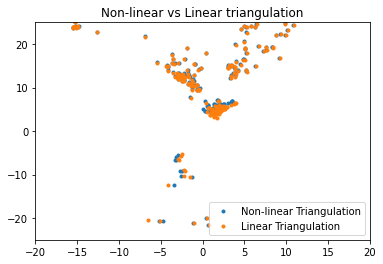

In [19]:
bestWP = np.reshape(X, (inliers1and2.shape[0],3))
plt.scatter(bestWP[:,0], bestWP[:,2], marker = '.', cmap = "spring", label = "Non-linear Triangulation")
plt.scatter(Xbest[:,0], Xbest[:,2],  marker = '.', cmap = "cool", label = "Linear Triangulation")
plt.legend()
plt.title("Non-linear vs Linear triangulation")
plt.xlim([-20,20])
plt.ylim([-25,25])
plt.show()

In [9]:
# import copy
# Xfinal = np.reshape(X, (int(X.shape[0]/3), 3))
# print(Xfinal.shape)
# def check(K, R1, C1, R2, C2, X):
#   temp1 = np.hstack((np.identity((3)),-C1))
#   PM1 = np.matmul(K, np.matmul(R1,temp1))
#   temp2 = np.hstack((np.identity((3)),-C2))
#   PM2 = np.matmul(K, np.matmul(R2,temp2))
#   # print(f"{PM1.shape} and {PM2.shape}")
#   X = np.hstack((X, np.ones((X.shape[0],1))))
#   Xt = X.transpose()
#   x1 = np.matmul(PM1, Xt).transpose()
#   x2 = np.matmul(PM2, Xt).transpose()
#   print(f"x1 = {x1.shape} and x2 = {x2.shape}")
#   return x1, x2

# temp1, temp2 = check(K, np.eye(3), np.zeros((3,1)), Rbest, Cbest, Xfinal)
# newx1 = temp1[:,:2]
# newx2 = temp2[:,:2]


# def DrawCheck(i, inliers_a, inliers_b):
#     img = cv2.imread('/content/gdrive/MyDrive/Colab Notebooks/P3Data/' + str(i) + '.png')
#     # img2 = cv2.imread('/content/gdrive/MyDrive/Colab Notebooks/P3Data/' + str(j) + '.png')
#     img1 = img.copy()
#     img2 = img.copy()
#     rows1, cols1 = img1.shape[:2]

#     radius = 4
#     BLUE = (255, 0, 0)
#     GREEN = (0, 255, 0)
#     RED = (0, 0, 255)
#     thickness = 1

#     assert len(inliers_a) == len(inliers_b), "inliers in images not equal"
#     for m in range(0, len(inliers_a)):

#         cv2.circle(img1, (int(inliers_a[m,0]), int(inliers_a[m,1])), radius,
#                    RED, -1)

#         cv2.circle(img2, (int(inliers_b[m][0]) + cols1, int(inliers_b[m][1])),
#                    radius, BLUE, -1)
        
#     cv2_imshow(img1)
#     cv2_imshow(img2)

# DrawCheck(1, inliers1and2[:,4:6], newx2)
# print(inliers1and2[:,4:6].shape)

In [10]:
matches1and2 = findMatches(1,2)
matches1and3 = findMatches(1,3)
matches1and4 = findMatches(1,4)
matches1and5 = findMatches(1,5)
matches2and3 = findMatches(2,3)
matches2and4 = findMatches(2,4)
matches2and5 = findMatches(2,5)
matches3and4 = findMatches(3,4)
matches3and5 = findMatches(3,5)
# print(matches1and2)

In [11]:
"""DO not Delete"""
# file = open('/content/gdrive/MyDrive/Colab Notebooks/P3Data/'+ 'matching' + str(1) + '.txt')

# feature_list = []
# for pos, l_num in enumerate(file):
#    if pos!=0:
#       split_line = list(l_num.split())
#       temp_dict = {"rgb_value":[split_line[1:4]], "self_img_point":split_line[4:6]}
#       x = 6
#       while x<len(split_line):
#           temp_dict[str(split_line[x])] = split_line[x+1:x+3]
#           x+=3
#       feature_list.append(temp_dict)
# print(feature_list)
# image_2 = []
# image_3 = []
# image_4 = []
# image_5 = []
# for item in feature_list:
 
#   if str(2) in item:
#     temp_dict_2 = {"rgb_value":item["rgb_value"], "self_img_point":item["self_img_point"]}
#     temp_dict_2["image_2_match_point"] = item[str(2)]
#     image_2.append(temp_dict_2)

#   if str(3) in item:
#      temp_dict_3 = {"rgb_value":item["rgb_value"], "self_img_point":item["self_img_point"]}
#      temp_dict_3["image_3_match_point"] = item[str(3)]
#      image_3.append(temp_dict_3)

#   if str(4) in item:
#     temp_dict_4 = {"rgb_value":item["rgb_value"], "self_img_point":item["self_img_point"]}
#     temp_dict_4["image_4_match_point"] = item[str(4)]
#     image_4.append(temp_dict_4)

#   if str(5) in item:
#     temp_dict_5 = {"rgb_value":item["rgb_value"], "self_img_point":item["self_img_point"]}
#     temp_dict_5["image_5_match_point"] = item[str(5)]
#     image_5.append(temp_dict_5)

"""C"""
# # x=matches1and2[:,7:9]
# # y=matches1and2[:,4:6]
# # print(x,y)
# # xnew = []
# # for row in x:
# #   if row[0] != -1:
# #     xnew.append(row)
# # xnew = np.array(xnew)
# # print(xnew.shape)

# def matches_check(x,y):
#   xnew = []
#   ynew = []
#   # if x.shape[1] == 8:
#   #   for row in x:
#   #     if x[7] != -1:
#   #       xnew.append(row)
#   #   xnew = np.array(xnew)
#   #   for row in x:
#   #     if y[7] != -1:
#   #       xnew.append(row)
#   #   xnew = np.array(ynew)


'C'